# **Lab 4.2 NN MLP and CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.xdatasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [ ]:
def load_data(path, class_names, print_info=True):
    ### START CODE HERE ###

    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Pad(10),
        transforms.RandomRotation(45, fill=255),
        transforms.CenterCrop(28)
    ])

    full_dataset = ImageFolder(root=path, transform=transform)
    class_indices = dict()
    for i, (_, label) in enumerate(full_dataset.samples):
        if label in class_names:
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(i)
    
    for cls in class_indices.keys():
        np.random.shuffle(class_indices[cls])

    train_indices, test_indices = [], []
    for label in class_names:
        indices = class_indices[label]
        split = int(0.8 * len(indices))
        train_indices += indices[:split]
        test_indices += indices[split:]

    train_set = Subset(full_dataset, train_indices)
    test_set = Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

    # Print dataset info
    if print_info:
        print("Train Dataset:")
        for label in class_names:
            count = sum(1 for i in train_indices if full_dataset.samples[i][1] == label)
            print(f"\tNumber of images in class {label}: {count}")
        print(f"\tNumber of training samples: {len(train_indices)}\n")

        print("Test Dataset:")
        for label in class_names:
            count = sum(1 for i in test_indices if full_dataset.samples[i][1] == label)
            print(f"\tNumber of images in class {label}: {count}")
        print(f"\tNumber of testing samples: {len(test_indices)}")

    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of training samples: 621

Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of testing samples: 156


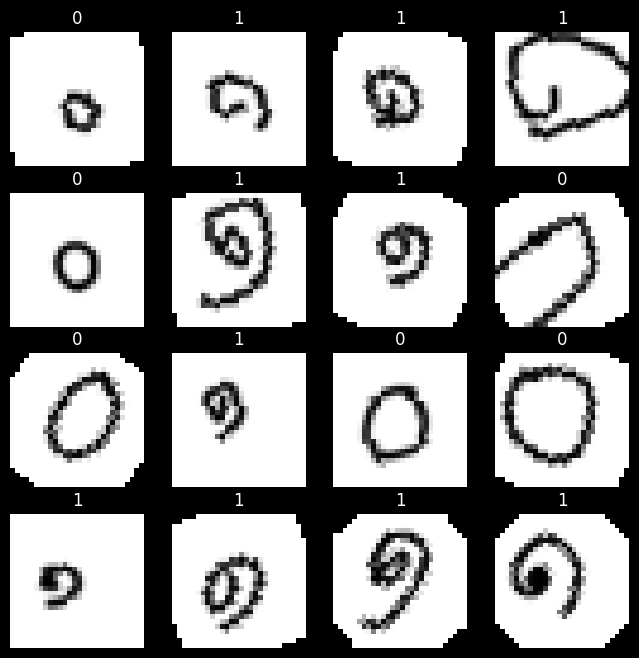

In [ ]:
### START CODE HERE ###
class_names = (0, 1)
train_loader, test_loader = load_data("./thai-handwriting-number", class_names)

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.set_facecolor('black')
for i in range(4):
    for j in range(4):
        img, label = next(iter(train_loader))
        axs[i, j].imshow(img[0][0], cmap='gray')
        axs[i, j].set_title(f"{label[0]}")
        axs[i, j].title.set_color('white')
        axs[i, j].axis('off')

### END CODE HERE ###

In [5]:
# This is a simple feedforward neural network with a 
# single fully connected layer. It takes input images, 
# flattens them, passes through a fully connected layer, 
# and applies sigmoid activation to produce the output
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features= 28 * 28,out_features= 1)
        self.sigmoid = nn.Sigmoid()

    def get_features(self,x):
        input_layer = x
        flatten_layer = self.flatten(input_layer)
        fc_layer = self.fc(flatten_layer)
        sigmoid_layer = self.sigmoid(fc_layer)

        return input_layer, flatten_layer, fc_layer, sigmoid_layer

    def forward(self, x):
        x = self.get_features(x)[-1]
        return x



# This is a multi-layer perceptron with two fully connected layers. 
# After flattening the input images, it passes through the first fully 
# connected layer with sigmoid activation, followed by the second fully 
# connected layer with sigmoid activation, producing the output.

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=28 * 28, out_features=16)
        self.sigmoid1 = nn.Sigmoid()

        self.fc2 = nn.Linear(in_features=16, out_features=1)
        self.sigmoid2 = nn.Sigmoid()

    def get_features(self, x):
        input_layer = x
        flatten_layer = self.flatten(input_layer)
        fc1_layer = self.fc1(flatten_layer)
        sigmoid1_layer = self.sigmoid1(fc1_layer)

        fc2_layer = self.fc2(sigmoid1_layer)
        sigmoid2_layer = self.sigmoid2(fc2_layer)

        return input_layer, flatten_layer, fc1_layer, sigmoid1_layer, fc2_layer, sigmoid2_layer

    def forward(self, x):
        x = self.get_features(x)[-1]
        return x


# This is a convolutional neural network with two convolutional layers 
# followed by two fully connected layers. It applies convolutional operations 
# with ReLU activations, followed by flattening the output and passing 
# through fully connected layers with ReLU activations. Finally, it produces 
# a single neuron output with sigmoid activation.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=32 * 24 * 24, out_features=128)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=128, out_features=1)
        self.sigmoid = nn.Sigmoid()
    
    def get_features(self, x):
        input_layer = x

        conv1_layer = self.conv1(input_layer)
        relu1_layer = self.relu1(conv1_layer)

        conv2_layer = self.conv2(relu1_layer)
        relu2_layer = self.relu2(conv2_layer)

        flatten_layer = self.flatten(relu2_layer)

        fc1_layer = self.fc1(flatten_layer)
        relu3_layer = self.relu3(fc1_layer)

        fc2_layer = self.fc2(relu3_layer)
        sigmoid_layer = self.sigmoid(fc2_layer)

        return input_layer, conv1_layer, relu1_layer, conv2_layer, relu2_layer, flatten_layer, fc1_layer, relu3_layer, fc2_layer, sigmoid_layer

    def forward(self, x):
        x = self.get_features(x)[-1]
        return x


Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [ ]:
def show_featuremaps(feats: torch.Tensor):
    feats = [feat.detach().cpu() for feat in feats]
    fig, axs = plt.subplots(1, len(feats), figsize=(12, 4))
    
    for i, feat in enumerate(feats):
        axs[i].axis('off')
        if feat.shape == (1, 1):
            axs[i].imshow(feat, cmap='viridis', vmax=1, vmin=0)

        elif feat.dim() == 2:
            feat = feat.T
            axs[i].imshow(feat, cmap='viridis', aspect='auto')
        
        else :
            feat = feat.squeeze(0)
            feat= feat.reshape(feat.shape[0]*feat.shape[1], feat.shape[2], 1)
            axs[i].imshow(feat, cmap='viridis', aspect='equal')
    return fig

TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [ ]:
def train(class_names,model: nn.Module, opt,loss_fn,train_loader,test_loader,epochs=10,writer=None,checkpoint_path=None,device='cpu'):
    ### START CODE HERE ###
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            #Forward
            outputs = model(images)
            remapped_labels = (labels == labels.max()).float()
            loss = loss_fn(outputs.squeeze(), remapped_labels)

            # Backward
            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item() * images.size(0)
            predict = (outputs.squeeze() > 0.5).float()
            train_correct += (predict == labels).sum().item()
            train_total += labels.size(0)
            
        train_loss /= train_total
        train_acc = train_correct / train_total

        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                remapped_labels = (labels == labels.max()).float()
                loss = loss_fn(outputs.squeeze(), remapped_labels)

                test_loss += loss.item() * images.size(0)
                preds = (outputs.squeeze() > 0.5).float()
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)

        test_loss /= test_total
        test_acc = test_correct / test_total

        if writer:
            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Accuracy/Train", train_acc, epoch)
            writer.add_scalar("Loss/Test", test_loss, epoch)
            writer.add_scalar("Accuracy/Test", test_acc, epoch)

            sample_img, _ = next(iter(test_loader))
            sample_img = sample_img[0].unsqueeze(0).to(device)

            with torch.no_grad():
                feats = model.get_features(sample_img)
                fig = show_featuremaps(feats)
                writer.add_figure("FeatureMaps", fig, global_step=epoch)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Save model
    if checkpoint_path:
        torch.save(model.state_dict(), checkpoint_path)

    ### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [3]:
### START CODE HERE ###
def generate_class_pair():
    class_pairs = []
    for i in range(10):
        for j in range(i + 1, 10):
            class_pairs.append((i, j))
    return class_pairs
class_pairs = generate_class_pair()


### END CODE HERE ###

Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>

In [26]:
### START CODE HERE ###
models = ['NN', 'MLP', 'CNN']

for (cl1, cl2) in class_pairs:
    print(cl1, cl2, "loading data...")
    train_loader, test_loader = load_data("./thai-handwriting-number", (cl1, cl2))
    
    for model in models:
        if model == 'NN':
            train_model = NN()
        elif model == 'MLP':
            train_model = MLP()
        else:
            train_model = CNN()
            
        save_path = f'{cl1}_{cl2}/{model}'
        checkpoint_path = f'checkpoints/{save_path}.pth'
        writer = SummaryWriter(log_dir=f"./runs/{save_path}")
        
        optimizer = optim.Adam(train_model.parameters(), lr=0.001)
        loss_fn = nn.BCELoss()
        
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        train(
            class_names=(cl1, cl2),
            model=train_model,
            opt=optimizer,
            loss_fn=loss_fn,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=10,
            writer=writer,
            checkpoint_path=checkpoint_path,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        print("finish training a model")

writer.close()

# tensorboard --logdir=runs
### END CODE HERE ###

0 1 loading data...
Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of training samples: 621

Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of testing samples: 156
Epoch [1/10] Train Loss: 0.6947, Train Acc: 0.5507 | Test Loss: 0.7061, Test Acc: 0.6410
Epoch [2/10] Train Loss: 0.6884, Train Acc: 0.5427 | Test Loss: 0.5940, Test Acc: 0.5897
Epoch [3/10] Train Loss: 0.6589, Train Acc: 0.6071 | Test Loss: 0.7812, Test Acc: 0.6603
Epoch [4/10] Train Loss: 0.6429, Train Acc: 0.6490 | Test Loss: 0.5782, Test Acc: 0.6987
Epoch [5/10] Train Loss: 0.6293, Train Acc: 0.6490 | Test Loss: 0.6115, Test Acc: 0.6923
Epoch [6/10] Train Loss: 0.6127, Train Acc: 0.7118 | Test Loss: 0.6806, Test Acc: 0.7821
Epoch [7/10] Train Loss: 0.5971, Train Acc: 0.7327 | Test Loss: 0.7618, Test Acc: 0.7628
Epoch [8/10] Train Loss: 0.5942, Train Acc: 0.7279 | Test Loss: 0.6380, Test Acc: 0.7500
Epoch [9/10] Train Loss: 0.5710, Train 

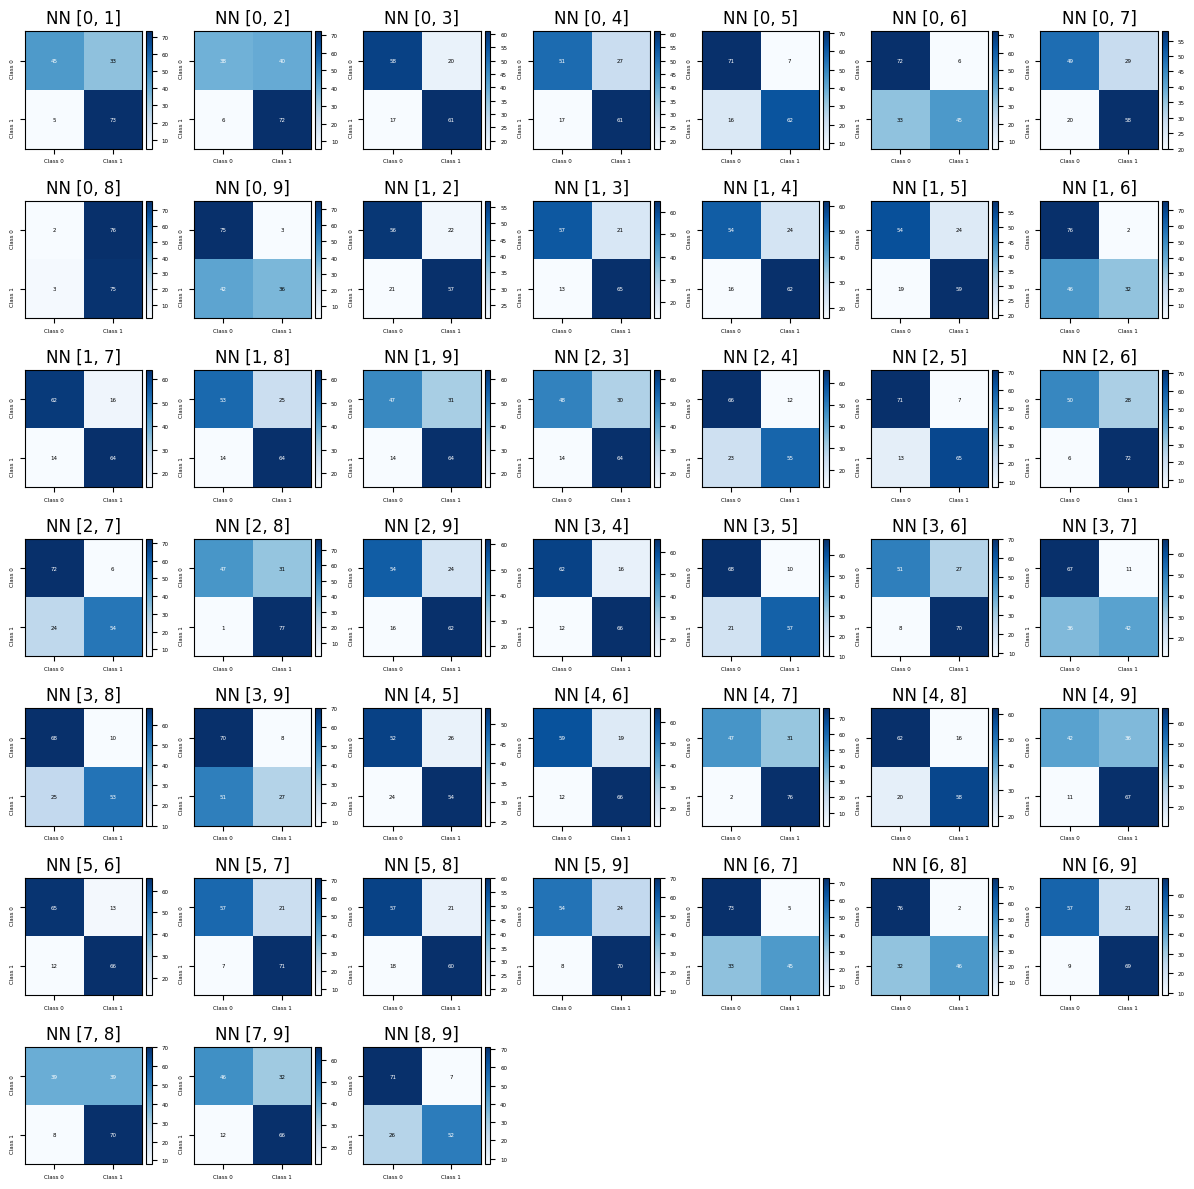

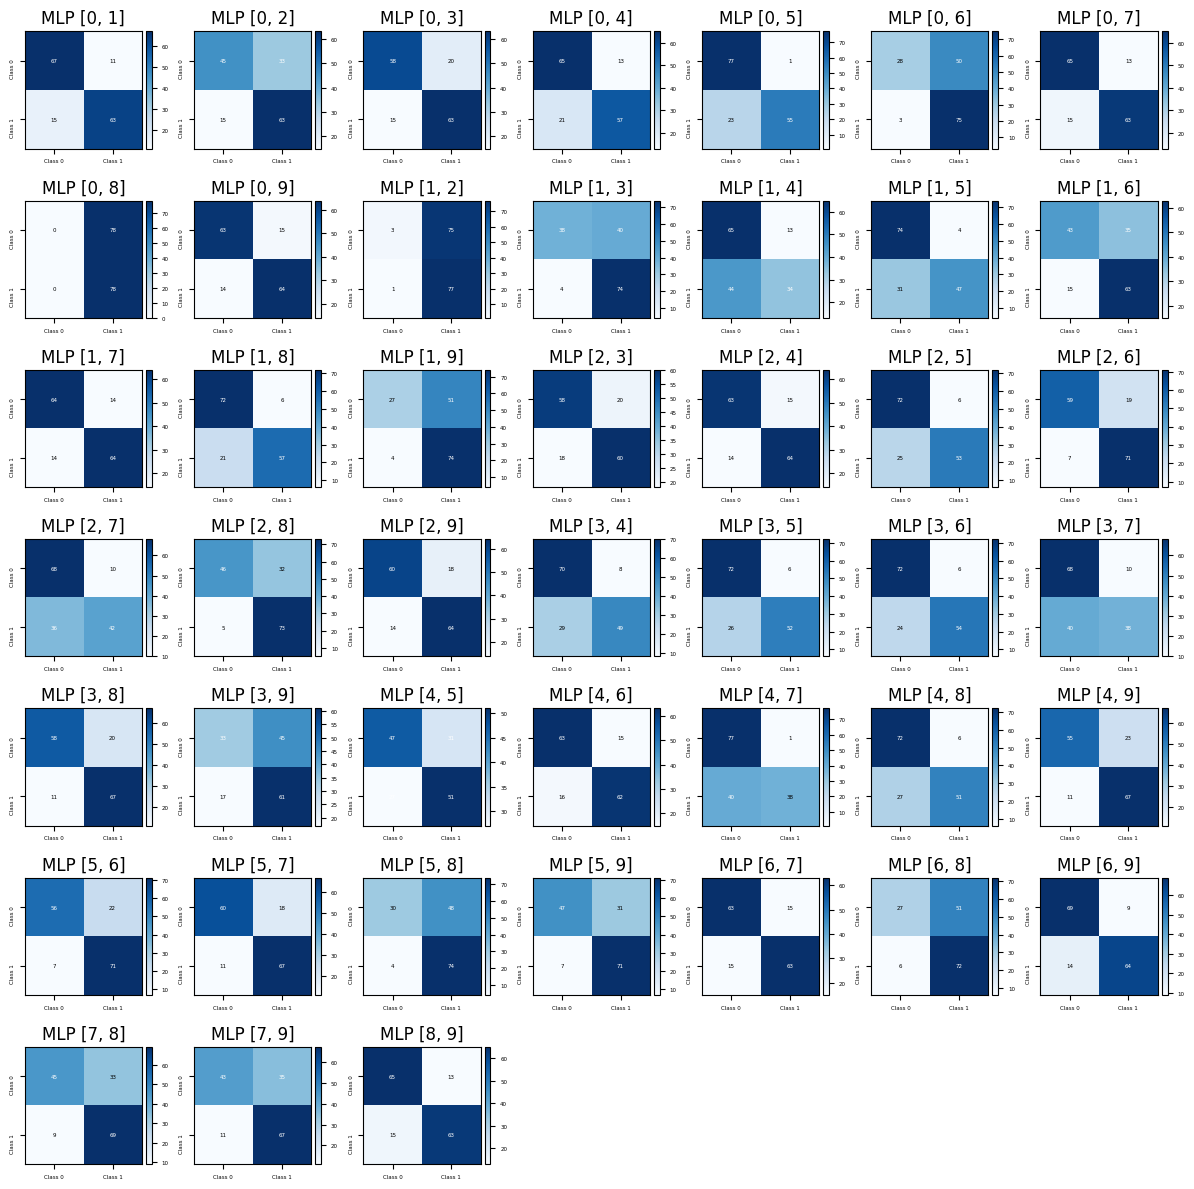

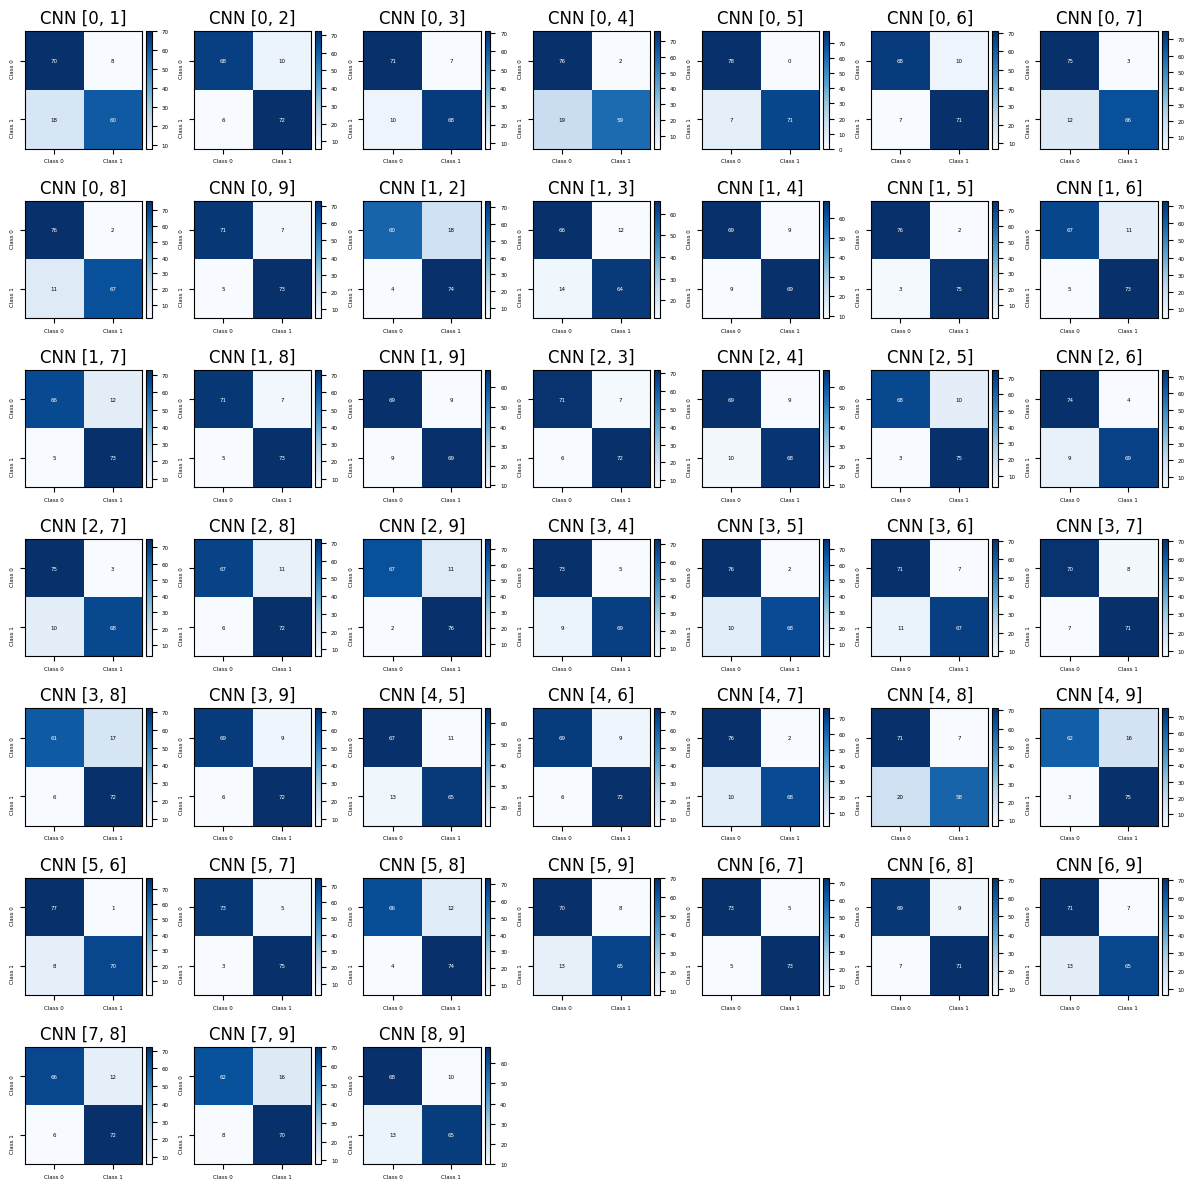

In [8]:
### START CODE HERE ###
def create_confusion_matrix(model, dataloader, class_names):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs
            labels = [class_names.index(label.item()) for label in labels]
            labels = torch.tensor(labels)

            # Ensure both inputs and model are on the same device
            device = next(model.parameters()).device
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (outputs.squeeze() > 0.5).long().cpu()

            y_true.extend(labels)
            y_pred.extend(preds)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return confusion_matrix(y_true, y_pred, labels=[0, 1])

def create_confusion_matrix_model(model_name):
    fig, axs = plt.subplots(7, 7, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    axs = axs.flatten()

    for idx, (cl1, cl2) in enumerate(class_pairs):
        if model_name == 'NN':
            model = NN()
        elif model_name == 'MLP':
            model = MLP()
        else:
            model = CNN()

        weight_path = f'checkpoints/{cl1}_{cl2}/{model_name}.pth'
        model.load_state_dict(torch.load(weight_path))
        model.eval()

        train_loader, test_loader = load_data("./thai-handwriting-number", (cl1, cl2), False)

        cm = create_confusion_matrix(model, test_loader, (cl1, cl2))
        ax = axs[idx]
        im = ax.imshow(cm, cmap='Blues')
        ax.set_title(f"{model_name} [{cl1}, {cl2}]")
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Class 0', 'Class 1'], fontsize=4)
        ax.set_yticklabels(['Class 0', 'Class 1'], fontsize=4, rotation=90)
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.03)
        cbar.ax.tick_params(labelsize=4)

        for i in range(2):
            for j in range(2):
                ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black', fontsize=4)

    for i in range(len(class_pairs), len(axs)):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

model_names = ['NN', 'MLP', 'CNN']
for model_name in model_names:
    create_confusion_matrix_model(model_name)
### END CODE HERE ###

Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?\
Ans. \
ความแม่นยำของแต่ละ model จะเปลี่ยนแปลงไปตามคู่ของตัวเลข โดยคู่เลขที่มีความแตกต่างกันชัดเจน เช่น 0 กับ 2 จะมีความแม่นยำสูงขึ้น โดยสามารถเรียงลำดับประสิทธิภาพได้ดังนี้ CNN > MLP > NN เพราะ cnn ดึง feature ได้มากที่สุด ส่วน nn ดึง feature มาน้อยที่สุด

2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.\
Ans. \
คู่ที่มีรูปร่างต่างกันชัดเจนจะมีความแม่นยำมากสุด เพราะสามารถแยกแยะได้ง่าย เช่น 0, 7 เป็นต้น

3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.\
Ans. 
- MLP มี hidden layer เพิ่มมากจา NN ทำให้เรียนรู้ pattern ที่ซับซ้อนขึ้นได้ \
- CNN มี conv layer ที่จะดึง feature เฉพาะของภาพได้มากขึ้น เช่น ขอบ เส้นโค้งต่างๆ\
- NN จะมีประสิทธิภาพใกล้เคียง MLP หรือ CNN ก็ต่อเมื่อคู่เลขต่างกันชัดเจน เช่น 0,  

4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.\
Ans.
- NN
    - ลด noise ของภาพ
    - เพิ่ม contrast ให้ pattern ชัดขึ้น
- MLP
    - เพิ่ม hidden layer
- CNN
    - เพิ่ม conv layer
    - crop, หมุนภาพ เพื่อให้ได้ข้อมูลที่หลากหลายมากขึ้น
  